In [ ]:
import os 

# os.environ['GO_EMOTIONS_COLAB_WORKDIR'] = '/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks'
colab_workdir = os.environ.get('GO_EMOTIONS_COLAB_WORKDIR')

if colab_workdir:
    print('Running with colab')
    from google.colab import drive
    drive.mount('/content/drive')
    %cd $colab_workdir
    !pip install -q -r ../requirements.txt
else:
    print('Running with jupyter notebook')

Running with colab
Mounted at /content/drive
/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks
     |████████████████████████████████| 3.8 MB 6.3 MB/s 
     |████████████████████████████████| 76 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 54.5 MB/s 
     |████████████████████████████████| 895 kB 66.4 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 6.5 MB 55.9 MB/s 


In [ ]:
%run library_utils.ipynb

import numpy as np 
import matplotlib.pyplot as plt
import torch 
import transformers
import torch.nn as nn
assert transformers.__version__ >= '4.17.0'
from transformers import (
    AutoTokenizer, 
    AutoModel)
import matplotlib.pyplot as plt
from tqdm import tqdm; tqdm.pandas()
from tqdm.notebook import tqdm 
from torch import Tensor
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter1d


module = 'go-emotion-gru-default'
model_filename = os.getcwd() + '/go-emotion-gru.py'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
%%writefile ../config/variant_gru_small.yaml
model_name: 'go-emotion-gru-small'
encoder_name: 'prajjwal1/bert-small'
fc_hiddens: [75, 75]

Overwriting ../config/variant_gru_small.yaml


In [ ]:
args = load_args(module, 'variant_gru_small', device=device)
init_seed(args.seed)

device: cuda


### Tokenizer & Encoder

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.encoder_name)
encoder = AutoModel.from_pretrained(args.encoder_name)

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/111M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
X_tk = tokenize_bert_inputs(
  ['hello my name is jeongwon', 'what are you?'], 
  tokenizer, 
  maxlen=args.sentence_max_len
)
len(X_tk['input_ids'][0])

62

In [ ]:
%%time
dataset_path = os.path.join(args.output_dir, args.train_dataset_path)
assert os.path.exists(dataset_path)

train_dataset, val_dataset = generate_bert_dataset(
    dataset_path,     
    tokenizer, 
    emotions = args.emotions, 
    sentence_max_len = args.sentence_max_len, 
    split = args.validation_split_from_train
)

CPU times: user 4.07 s, sys: 163 ms, total: 4.24 s
Wall time: 3.6 s


In [ ]:
%%writefile $model_filename
class GoEmotionGRUClassifer(TransformerEncoderBase):
  def __init__(self, 
        encoder, 
        criterion=nn.BCEWithLogitsLoss(), 
        seq_len=82,
        rnn_hidden = 50,  
        rnn_num_layers = 1,
        bidirectional=True, 
        hiddens = None,
        dropout_p=0.1, 
        n_cls:int = 28
    ):
    config = {
        'seq_len': seq_len, 
        'rnn_hidden': rnn_hidden, 
        'rnn_num_layers': rnn_num_layers, 
        'bidirectional': bidirectional, 
        'hiddens':  [50] if hiddens is None else hiddens, 
        'dropout_p': dropout_p, 
        'n_cls': n_cls
    }
    super().__init__(encoder, criterion, config)

    # layers
    self.encoder = encoder
    self.gru = nn.GRU(
        input_size= self.encoder_dim, 
        hidden_size = rnn_hidden, 
        batch_first = True, 
        bidirectional = bidirectional
    )
    self.dropout = nn.Dropout(dropout_p)

    # full connected
    fcs = []
    in_feature = (int(bidirectional) + 1) * rnn_hidden
    for h in self.config['hiddens']:
      fcs.append(nn.Linear(in_feature, h))
      fcs.append(nn.ReLU())
      in_feature = h    
    
    # final layer 
    fcs.append(nn.Linear(in_feature, n_cls))
    self.fcs = nn.Sequential(*fcs)

  def forward(self, input_ids, attention_mask, y_true=None):
    encoder_output = super().forward(input_ids, attention_mask)
    contextual_emb = encoder_output['last_hidden_state']

    output, _ = self.gru(contextual_emb)
    output = output[:, -1, :]
    z = self.dropout(output) 
    logits = self.fcs(z)

    if not (y_true is None):
      loss = self.criterion(logits, y_true)
      return (loss, logits)

    return logits

Overwriting /content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks/go-emotion-gru.py


In [ ]:
with open(model_filename, 'r') as f:
  exec(f.read())

In [ ]:
def create_go_emotion_gru(args, encoder):
    return GoEmotionGRUClassifer(
        encoder, 
        seq_len=args.sentence_max_len,
        rnn_hidden=args.rnn_hidden, 
        rnn_num_layers = args.rnn_num_layers, 
        bidirectional=args.bidirectional, 
        hiddens = args.fc_hiddens, 
        dropout_p = args.dropout_p, 
        n_cls = len(args.emotions)
    )

model = create_go_emotion_gru(args, encoder)
model

GoEmotionGRUClassifer(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_

In [ ]:
def proba_on_examples(texts, model):
    X_tk = tokenize_bert_inputs(
        texts, tokenizer, maxlen = args.sentence_max_len
    )
    X_tk['input_ids'] = Tensor(X_tk['input_ids']).type(torch.int32)
    X_tk['attention_mask'] = Tensor(X_tk['attention_mask']).type(torch.int32)
    proba = predict_proba_examples(X_tk, model)
    return proba

In [ ]:
proba = proba_on_examples(['hello my name is jeongwon', 'nice to meet you!'], model)
proba_to_emotion(
    proba,
    args.classification_threshold, 
    args.emotions, 
)[0][:3]

[('admiration', 0.5224104), ('amusement', 0.49510267), ('anger', 0.5193386)]

In [ ]:
proba = predict_proba_examples(val_dataset[:5], model)
y_true = val_dataset[:5]['y_true'].numpy()
compute_classification_metrics(y_true, proba, 0.1)

{'accuracy': 0.08888888888888889,
 'macro_f1': 0.1388888888888889,
 'macro_precision': 0.0888888888888889,
 'macro_recall': 0.37037037037037035,
 'micro_f1': 0.163265306122449,
 'micro_precision': 0.08888888888888889,
 'micro_recall': 1.0,
 'weighted_f1': 0.4375,
 'weighted_precision': 0.3,
 'weighted_recall': 1.0}

In [ ]:
evaluate(
    model, 
    val_dataset, 
    batch_size = args.eval_batch_size, 
    threshold = args.classification_threshold, 
    device = args.device
)

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

{'accuracy': 0.09182376934441128,
 'auc_roc_macro': 0.49473570107562415,
 'auc_roc_micro': 0.45602565644147003,
 'loss': 0.6967941900389788,
 'macro_f1': 0.16367734037903445,
 'macro_precision': 0.09182376934441129,
 'macro_recall': 1.0,
 'micro_f1': 0.16820254682593533,
 'micro_precision': 0.09182376934441128,
 'micro_recall': 1.0,
 'trigger_rate': 1.0,
 'weighted_f1': 0.21748397449122542,
 'weighted_precision': 0.12487152052348784,
 'weighted_recall': 1.0}

In [ ]:
model = create_go_emotion_gru(args, encoder)
_ = save_checkpoint(
    model, 
    args.output_dir, 
    model_name='testmodel',
    metadata=args
)

model_copy, _ = load_from_checkpoint(
    args.output_dir,
    model_name='testmodel',
    checkpoint_id='null-model', 
    model_cls=GoEmotionGRUClassifer
)

check_model_same(model, model_copy)

True

In [ ]:
# clear_archive(args.output_dir, args.model_name)

In [ ]:
model = create_go_emotion_gru(args, encoder)
model, metadata = train(
    model, 
    train_dataset, 
    val_dataset, 
    dict(args), 
    tokenizer, 
    epochs=args.train_epochs, 
    train_batch_size = args.train_batch_size, 
    val_batch_size = args.eval_batch_size, 
    save_steps = args.save_steps, 
    validation_steps= args.validation_steps, 
    archive_dir = args.output_dir, 
    model_name = args.model_name, 
    classification_threshold = args.classification_threshold, 
    learning_rate = args.learning_rate, 
    grad_clip_max = args.grad_clip_max, 
    weight_decay = args.weight_decay, 
    warmup_ratio = args.warmup_ratio, 
    logging_metrics= ['macro_f1', 'macro_precision', 'macro_recall'],
    continue_training=False,
    device = args.device
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


training epoch 0


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 1


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 3000
val {'macro_precision': 0.027892993586678898, 'macro_recall': 0.2222222222222222, 'macro_f1': 0.04921220585846906}
tr {'macro_precision': 0.028049348230912475, 'macro_recall': 0.2222222222222222, 'macro_f1': 0.04949801687657179}
saving at step 3000
training epoch 2


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 6000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 6000
training epoch 3


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 4


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 9000
val {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
tr {'macro_precision': 0.0, 'macro_recall': 0.0, 'macro_f1': 0.0}
saving at step 9000
training epoch 5


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 12000
val {'macro_precision': 0.045855379188712526, 'macro_recall': 0.0013746170422826375, 'macro_f1': 0.0026547993524707316}
tr {'macro_precision': 0.05170755170755171, 'macro_recall': 0.0018666667821826926, 'macro_f1': 0.003559824561285353}
saving at step 12000
training epoch 6


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 15000
val {'macro_precision': 0.2819390027617, 'macro_recall': 0.12255883458602905, 'macro_f1': 0.14604410136973253}
tr {'macro_precision': 0.265648574788592, 'macro_recall': 0.12696972383130356, 'macro_f1': 0.15036337264969035}
saving at step 15000
training epoch 7


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 8


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 18000
val {'macro_precision': 0.3198685593705672, 'macro_recall': 0.18872983797344917, 'macro_f1': 0.21822880722876192}
tr {'macro_precision': 0.3559448232396929, 'macro_recall': 0.2115535509052888, 'macro_f1': 0.244432377371936}
saving at step 18000
training epoch 9


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 21000
val {'macro_precision': 0.4435220274838716, 'macro_recall': 0.2276117682771441, 'macro_f1': 0.2713023352716928}
tr {'macro_precision': 0.532762040169147, 'macro_recall': 0.25935797117091103, 'macro_f1': 0.30646515379991396}
saving at step 21000
training epoch 10


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 11


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 24000
val {'macro_precision': 0.5044203084792289, 'macro_recall': 0.28130671463028567, 'macro_f1': 0.3196111266211675}
tr {'macro_precision': 0.6037148818214357, 'macro_recall': 0.359050190492388, 'macro_f1': 0.40326997026128286}
saving at step 24000
training epoch 12


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 27000
val {'macro_precision': 0.43320247838972864, 'macro_recall': 0.3324941527844074, 'macro_f1': 0.3693510767373277}
tr {'macro_precision': 0.5948488433899699, 'macro_recall': 0.438176059489454, 'macro_f1': 0.4775855221938277}
saving at step 27000
training epoch 13


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 30000
val {'macro_precision': 0.45969883098342995, 'macro_recall': 0.3334913141464877, 'macro_f1': 0.3735224355247748}
tr {'macro_precision': 0.5992571459486437, 'macro_recall': 0.4539518342277639, 'macro_f1': 0.4966473106023487}
saving at step 30000
training epoch 14


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 15


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 33000
val {'macro_precision': 0.41888225708536403, 'macro_recall': 0.3580151832251675, 'macro_f1': 0.3777379933901251}
tr {'macro_precision': 0.6330678305990531, 'macro_recall': 0.5409563589375029, 'macro_f1': 0.5640165645259944}
saving at step 33000
training epoch 16


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 36000
val {'macro_precision': 0.44308158433740136, 'macro_recall': 0.34627203118731315, 'macro_f1': 0.37993349117209074}
tr {'macro_precision': 0.6988780425949034, 'macro_recall': 0.5327123514825112, 'macro_f1': 0.5681981618294057}
saving at step 36000
training epoch 17


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

training epoch 18


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 39000
val {'macro_precision': 0.4862393573056028, 'macro_recall': 0.3590191923436589, 'macro_f1': 0.3877526757420774}
tr {'macro_precision': 0.7271381805406837, 'macro_recall': 0.5996490279507819, 'macro_f1': 0.624551302832339}
saving at step 39000
training epoch 19


Training:   0%|          | 0/2150 [00:00<?, ?it/s]

evaluation:   0%|          | 0/538 [00:00<?, ?it/s]

evaluation:   0%|          | 0/537 [00:00<?, ?it/s]

evaluating at step 42000
val {'macro_precision': 0.4824365660877955, 'macro_recall': 0.3755191886919827, 'macro_f1': 0.39479700330718553}
tr {'macro_precision': 0.7421041476926318, 'macro_recall': 0.6308267135379276, 'macro_f1': 0.6504732095692093}
saving at step 42000


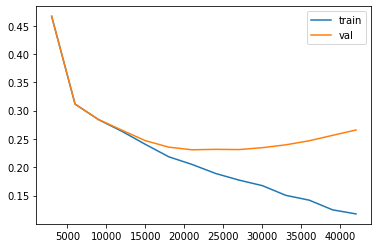

,tr_metrics.loss,tr_metrics.trigger_rate,val_metrics.loss,val_metrics.trigger_rate,val_metrics.accuracy,val_metrics.macro_f1,val_metrics.micro_f1,checkpoint_id
0,0.487360,0.222222,0.487673,0.222222,0.741740,0.049212,0.177636,3000
1,0.291041,0.000000,0.291009,0.000000,0.908176,0.000000,0.000000,6000
2,0.285820,0.000000,0.285977,0.000000,0.908176,0.000000,0.000000,9000


In [ ]:
df = get_attrs_from_checkpoints_meta(args.output_dir, args.model_name, [
    'tr_metrics.loss', 
    'tr_metrics.trigger_rate',
    'val_metrics.loss', 
    'val_metrics.trigger_rate', 
    'val_metrics.accuracy', 
    'val_metrics.macro_f1',
    'val_metrics.micro_f1'
])

std = 0.5
plt.plot(df['checkpoint_id'], gaussian_filter1d(df['tr_metrics.loss'], std), label='train')
plt.plot(df['checkpoint_id'], gaussian_filter1d(df['val_metrics.loss'], std), label='val')
plt.legend()
plt.show()

df.head(3)

In [ ]:
df.sort_values(by='val_metrics.loss').head(1)

,tr_metrics.loss,tr_metrics.trigger_rate,val_metrics.loss,val_metrics.trigger_rate,val_metrics.accuracy,val_metrics.macro_f1,val_metrics.micro_f1,checkpoint_id
6,0.205337,0.047917,0.230044,0.046582,0.915933,0.271302,0.392606,21000


In [ ]:
df.sort_values(by='val_metrics.macro_f1', ascending=False).head(1)

,tr_metrics.loss,tr_metrics.trigger_rate,val_metrics.loss,val_metrics.trigger_rate,val_metrics.accuracy,val_metrics.macro_f1,val_metrics.micro_f1,checkpoint_id
13,0.116797,0.086687,0.266897,0.083778,0.904924,0.394797,0.458572,42000


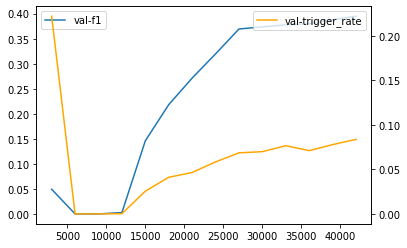

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df['checkpoint_id'], 
         df['val_metrics.macro_f1'], 
         label='val-f1')
ax2.plot(df['checkpoint_id'], 
         df['val_metrics.trigger_rate'], 
         label='val-trigger_rate', c='orange')

ax1.legend()
ax2.legend()

In [ ]:
best_checkpoint = int(df.sort_values(by='val_metrics.macro_f1', ascending=False).iloc[0]['checkpoint_id'])
print('checkpoint', best_checkpoint)
model, meta = load_from_checkpoint(args.output_dir, args.model_name, best_checkpoint, model_cls=GoEmotionGRUClassifer)

test_dataset = generate_bert_dataset(
    os.path.join(
        args.output_dir, 
        args.test_dataset_path), 
    tokenizer, 
    args.emotions, 
    args.sentence_max_len, 
)
print('test length', len(test_dataset))

proba = predict_proba(
    model, 
    test_dataset, 
    batch_size = args.eval_batch_size, 
    device = args.device
)
y_true = test_dataset[:]['y_true'].numpy()
roc_auc_score(y_true, proba, average='macro')

checkpoint 42000
test length 10748


evaluation:   0%|          | 0/672 [00:00<?, ?it/s]

0.7994526392399712

In [ ]:
compute_classification_metrics(
    test_dataset[:]['y_true'].numpy(), 
    proba, 0.4)

{'accuracy': 0.9050745013714868,
 'auc_roc_macro': 0.7994526392399712,
 'auc_roc_micro': 0.8397166131209968,
 'macro_f1': 0.39407164939360506,
 'macro_precision': 0.46380577265070416,
 'macro_recall': 0.3761282384294478,
 'micro_f1': 0.45927961527137107,
 'micro_precision': 0.48128188250781634,
 'micro_recall': 0.43920111123625033,
 'weighted_f1': 0.4480005036875487,
 'weighted_precision': 0.47499780051980484,
 'weighted_recall': 0.43920111123625033}

In [ ]:
results = compute_classification_metrics_per_class(
    test_dataset[:]['y_true'].numpy(), 
    proba, 
    # test_dataset[:]['y_true'].mean(axis=0).numpy(), 
    [0.4] * len(args.emotions)
)
df = pd.DataFrame(results)
df.index = args.emotions
df.round(2)[['precision', 'f1', 'trigger_rate', 'auc_roc']]#.to_latex(index=True, header=True,)

,precision,f1,trigger_rate,auc_roc
admiration,0.57,0.61,0.21,0.84
amusement,0.76,0.69,0.08,0.95
anger,0.44,0.46,0.12,0.88
annoyance,0.42,0.44,0.21,0.78
approval,0.45,0.44,0.24,0.72
caring,0.38,0.37,0.07,0.90
confusion,0.43,0.43,0.09,0.89
curiosity,0.62,0.65,0.12,0.92
desire,0.40,0.30,0.03,0.94
disappointment,0.35,0.31,0.10,0.84


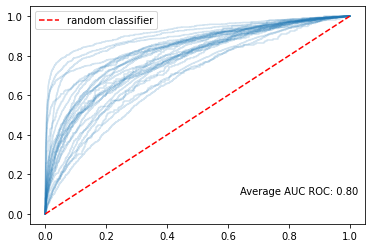

In [ ]:
for i, emt in enumerate(args.emotions):
    fpr, tpr, _ = roc_curve(y_true[:, i], proba[:, i])
    plt.plot(fpr, tpr, c='#1f77b4', alpha=0.2)
    # plt.title(emt)
    # plt.show()

x = np.linspace(0, 1, 300)
y = x
plt.plot(x, y, 'r--', label='random classifier')
plt.text(0.64, 0.1, 'Average AUC ROC: {:.2f}'.format(roc_auc_score(y_true, proba, average='macro')))
plt.legend()

In [ ]:
proba_to_emotion(
    proba_on_examples([
        'I hate this man', 
        'this is pretty dumb'
    ], model),
    0.4, 
    args.emotions)

[[('anger', 0.9331641), ('annoyance', 0.5631126), ('disgust', 0.66354364)],
 [('annoyance', 0.73340917),
  ('disapproval', 0.40471464),
  ('disgust', 0.7330637)]]